In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings

from sklearn.linear_model import LinearRegression

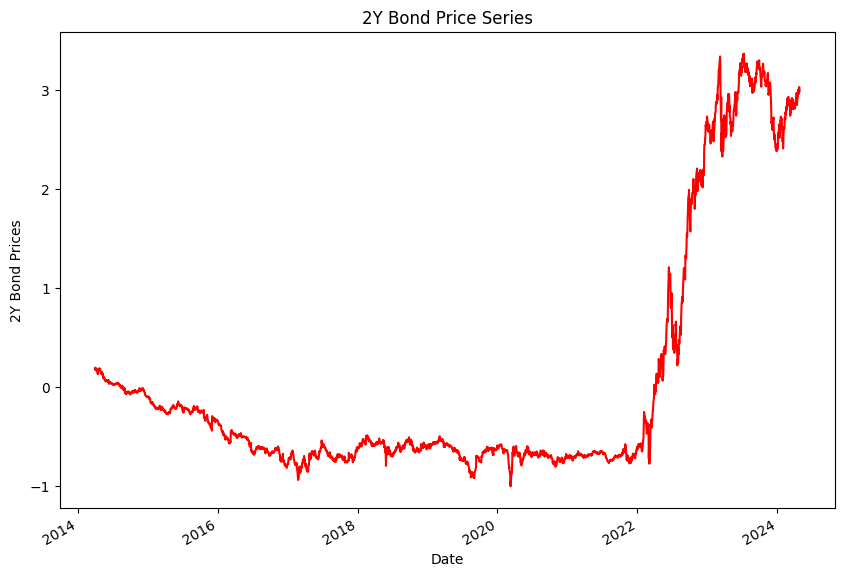

In [7]:
df  = pd.read_csv('2y_German_data.csv')
df = df[['Date', 'Price']] # only date and price data
df = df.iloc[::-1] # reverse for chronological order
df.set_index('Date', inplace=True) # set date as index
df.index = pd.to_datetime(df.index)
df.rename(columns={'Price': 'Close'}, inplace=True) # rename to Close for analysis

df = df.dropna()
df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("2Y Bond Prices")
plt.title("2Y Bond Price Series")
plt.show()

In [9]:
# train: use moving averages over last 3 days and 9 days 
df['S_3'] = df['Close'].rolling(window=3).mean()
df['S_9'] = df['Close'].rolling(window=9).mean()
df['next_day_price'] = df['Close'].shift(-1)

df = df.dropna()
x = df[['S_3', 'S_9']]

y = df['next_day_price']

# separate testing and training data
index = int(0.8*(len(df)))
x_train, x_test, y_train, y_test = x[:index], x[index:], y[:index], y[index:]

# train linear regression
linear = LinearRegression().fit(x_train, y_train)

print("Linear Regression model")
print("2Y Bond Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
2Y Bond Price (y) = 1.19 * 3 Days Moving Average (x1) + -0.20 * 9 Days Moving Average (x2) + -0.00 (constant)


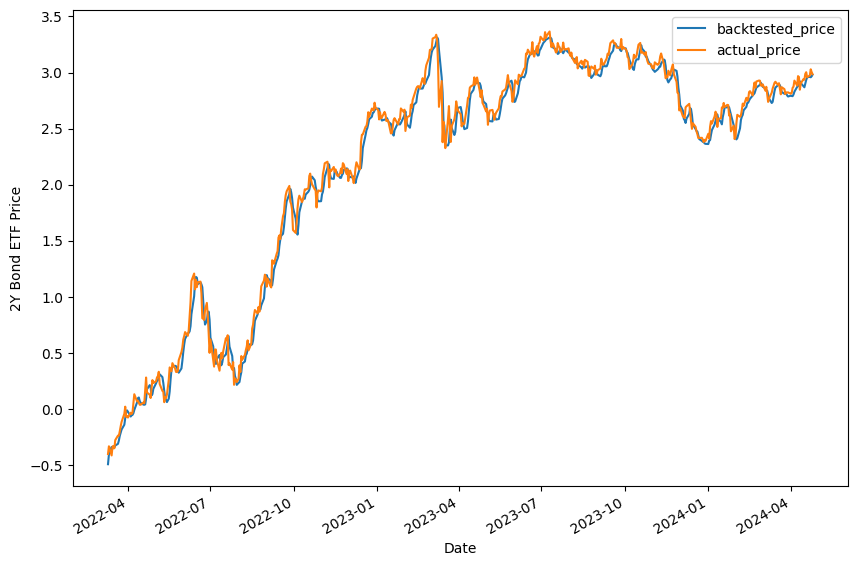

               price
Date                
2022-03-10 -0.491996
2022-03-11 -0.405516
2022-03-14 -0.337999
2022-03-15 -0.354990
2022-03-16 -0.334532
...              ...
2024-04-19  2.956313
2024-04-22  2.963415
2024-04-23  2.957734
2024-04-24  2.966532
2024-04-25  2.981334

[566 rows x 1 columns]


In [10]:
backtest_price = linear.predict(x_test)
backtest_price = pd.DataFrame(
    backtest_price, index=y_test.index, columns=['price'])
backtest_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['backtested_price', 'actual_price'])
plt.ylabel("2Y Bond ETF Price")
plt.show()

print(backtest_price)
# export to excel
export_df = pd.DataFrame({
    'dates': x_test.index,  # Assuming index contains dates
    'Historical Price': y_test,
    'Model Predicted Price': backtest_price['price']  # Assuming 'shuffle_predicted_price' is already defined
})

# Export the DataFrame to an Excel file
export_df.to_excel('2Y_German_backtest_results.xlsx', index=False)

In [11]:
# predict next three months of results
current_date = df.index[-1]
end_date = datetime(2024, 7, 31)

print("original df")
print(df)
while current_date <= end_date:
    # forecast the price
    df['predicted_price'] = linear.predict(df[['S_3', 'S_9']])
    last_row = df.tail(1)
    predicted_nlr_price = last_row['predicted_price'].iloc[-1]
    # print("predicted price: ", predicted_nlr_price)
    # print("after calculating predicted price")
    # print(df)

    last_date = df.index[-1]
    new_date = last_date + timedelta(days=1)
    current_date = new_date
    new_row = pd.DataFrame(index=[new_date], columns=df.columns)
    new_row['Close'] = predicted_nlr_price
    moving_avg_list = df['Close'].iloc[-8:].tolist()
    moving_avg_list.append(predicted_nlr_price)
    new_row['S_3'] = sum(moving_avg_list[-3:]) / 3
    new_row['S_9'] = sum(moving_avg_list) / 9
    warnings.filterwarnings("ignore", message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated.*")
    df = pd.concat([df, new_row])   
    # print("after adding new row")
    # print(df)

# adjust to only weekly data 
df = df.resample('W-FRI').last()
# export to excel
export_df = pd.DataFrame({
    'Dates': df.index, 
    'Historical Price': df['Close'], 
    'Base': df['predicted_price'],
})

# Export the DataFrame to an Excel file
export_df.to_excel('German_predicted_results.xlsx', index=False)

original df
            Close       S_3       S_9  next_day_price
Date                                                 
2014-04-11  0.160  0.168333  0.175444           0.158
2014-04-14  0.158  0.159333  0.172444           0.127
2014-04-15  0.127  0.148333  0.165111           0.140
2014-04-16  0.140  0.141667  0.160556           0.170
2014-04-17  0.170  0.145667  0.160889           0.177
...           ...       ...       ...             ...
2024-04-19  3.003  2.975667  2.936667           2.958
2024-04-22  2.958  2.983000  2.944889           2.974
2024-04-23  2.974  2.978333  2.945556           3.029
2024-04-24  3.029  2.987000  2.953222           3.004
2024-04-25  3.004  3.002333  2.970667           2.985

[2828 rows x 4 columns]


C:\Users\jyin1\AppData\Local\Temp\ipykernel_48636\3890753203.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_price'] = linear.predict(df[['S_3', 'S_9']])
